In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import _functions_sql as fs
import seaborn as sns

### Create a production table

In [58]:
# import production data from database
df_production = fs.get_dataframe('SELECT * FROM production_and_emissions')

In [11]:
df_production['item_category'].unique()

array(['Crops, primary', 'Crops Processed', 'Live Animals',
       'Livestock primary', 'Livestock processed'], dtype=object)

In [59]:
df_production.head()

,area,area_group,year,population,item,item_code,item_group,item_category,area_harvested_in_ha,stocks_in_an,...,emissions_ch4_in_kt,emissions_n2o_in_kt,emissions_co2eq_calc_in_kt,emissions_intensity_calc_in_kg_co2eq_per_kg,source_emissions,emissions_co2eq_in_kt,emissions_intensity_in_kg_co2eq_per_kg,production_emissions_in_t,emissions_intensity_combined_in_kg_co2eq_per_kg,emissions_co2eq_combined_in_kt
0,Central Asia,yes,2009,62633849,Safflower seed,280,Oilcrops Primary,"Crops, primary",209089.0,0.0,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None
1,Central Asia,yes,2009,62633849,"Safflower-seed oil, crude",281,-,Crops Processed,0.0,0.0,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None
2,Central Asia,yes,2009,62633849,"Seed cotton, unginned",328,-,"Crops, primary",2218618.0,0.0,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None
3,Central Asia,yes,2009,62633849,Sesame seed,289,Oilcrops Primary,"Crops, primary",4217.0,0.0,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None
4,Central Asia,yes,2009,62633849,Sheep,976,Sheep and Goats,Live Animals,0.0,45427326.0,...,231.6886,12.8892,10328.2624,NaN,FAO TIER 1,NaN,NaN,NaN,NaN,None


### Emissions and production development over time

In [51]:
# Create a list of items in the 'livestock_primary' category
livestock_primary = list(set(df_production[(df_production['item_category'] == 'Livestock primary') & (df_production['emissions_intensity_combined_in_kg_co2eq_per_kg'].notna())]['item'].tolist()))

In [42]:
# Create two separate lists for milk and meat items
livestock_meat = ['Meat of cattle with the bone, fresh or chilled',
 'Meat of buffalo, fresh or chilled',
 'Meat of pig with the bone, fresh or chilled',
 'Meat of sheep, fresh or chilled',
 'Meat of chickens, fresh or chilled',
 'Meat of goat, fresh or chilled']

livestock_milk = ['Raw milk of buffalo','Raw milk of goats','Raw milk of camel','Raw milk of sheep','Raw milk of cattle']

In [43]:
# Create a list of items in the 'crops_primary' category
crops_primary = list(set(df_production[(df_production['item_category'] == 'Crops, primary') & (df_production['emissions_intensity_combined_in_kg_co2eq_per_kg'].notna())]['item'].tolist()))

In [44]:
# Remove rice from the list
crops_primary_wo_rice = ['Maize (corn)','Sugar cane','Barley','Potatoes','Millet','Wheat','Soya beans','Rye','Oats','Sorghum','Beans, dry']

In [53]:
# Create a list for remaining items
rice_and_eggs = ['Hen eggs in shell, fresh', 'Rice']

In [16]:
emissions_intensity = df_production[['item', 'year', 'emissions_intensity_combined_in_kg_co2eq_per_kg']].groupby(['item', 'year'], as_index=False).agg('median')

In [18]:
emissions_intensity = emissions_intensity.dropna(subset=['emissions_intensity_combined_in_kg_co2eq_per_kg'])

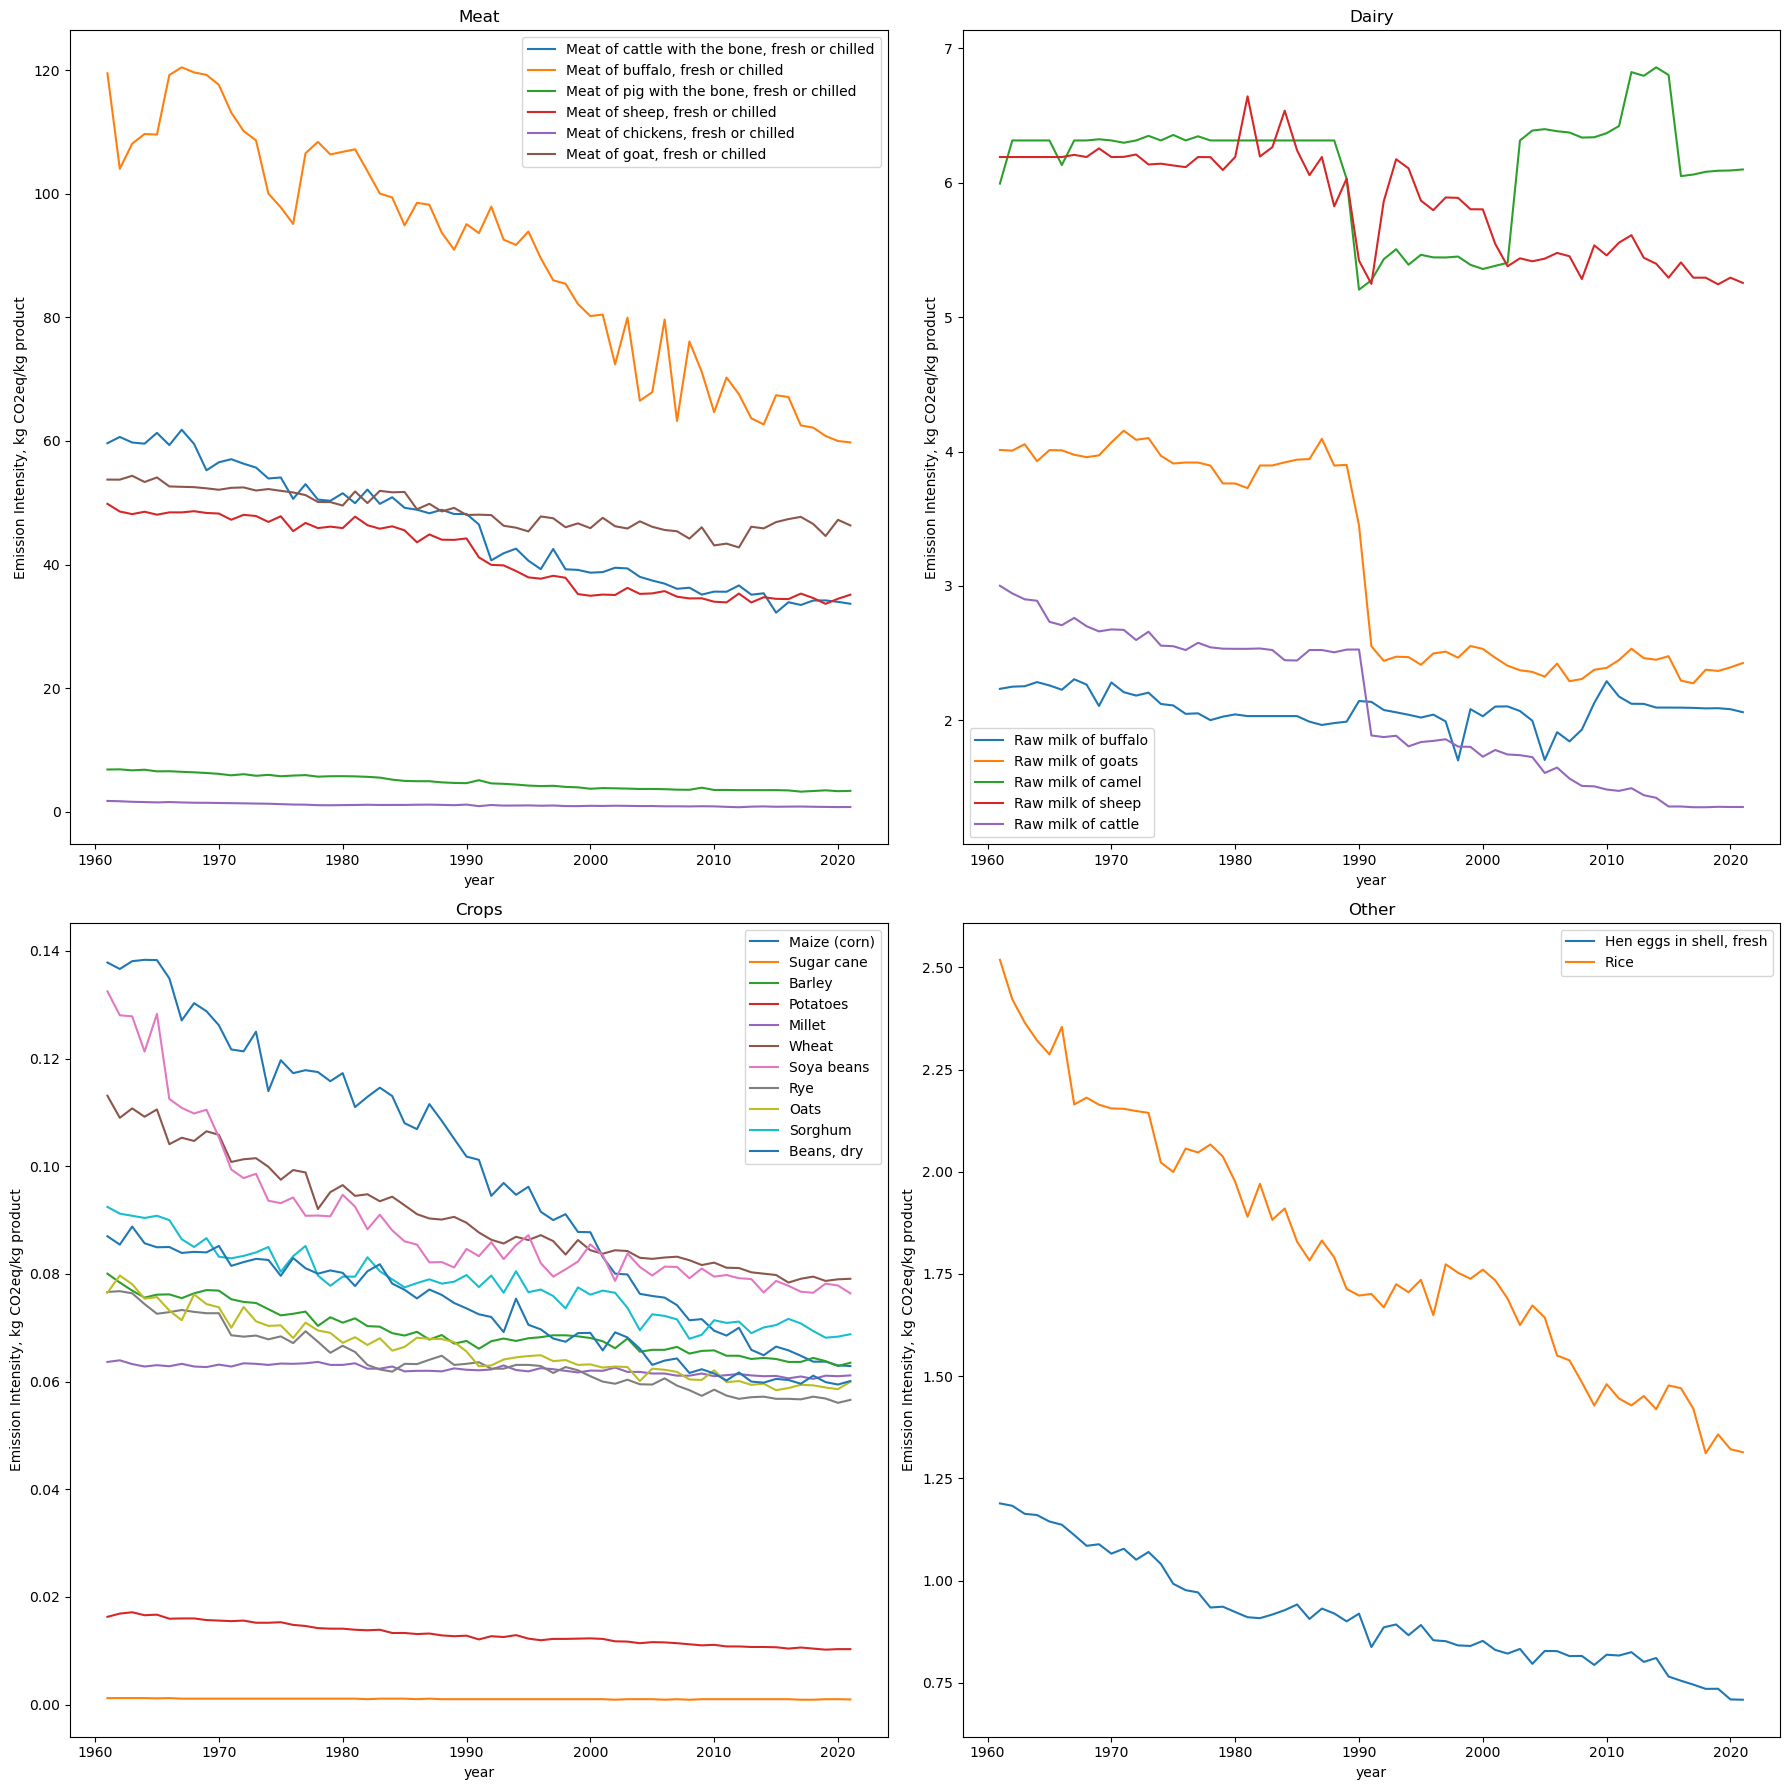

In [56]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18) )

# Iterate over livestock_meat items
for item in livestock_meat:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[0,0], label=item)

axes[0,0].legend()
axes[0,0].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[0,0].set_title('Meat')

# Iterate over livestock_meat items
for item in livestock_milk:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[0,1], label=item)

axes[0,1].legend()
axes[0,1].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[0,1].set_title('Dairy')

# Iterate over crop items
for item in crops_primary_wo_rice:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[1,0], label=item)

axes[1,0].legend()
axes[1,0].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[1,0].set_title('Crops')

# Iterate over other items
for item in rice_and_eggs:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[1,1], label=item)

axes[1,1].legend()
axes[1,1].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[1,1].set_title('Other')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

We see an overall decrease in emission intensity among different product groups. This trend is especially strong for rice, eggs and some of the meat products.

In [79]:
# Calculate total production amount per item and year
production_amount_item = df_production[['item', 'year', 'production_in_t']].groupby(['item', 'year'], as_index=False).agg('sum')

In [76]:
production_amount_item.head()

,item,year,production_in_t,population
0,"Abaca, manila hemp, raw",1961,389360.0,6067722006
1,"Abaca, manila hemp, raw",1962,449380.0,6193429575
2,"Abaca, manila hemp, raw",1963,561060.0,6341504033
3,"Abaca, manila hemp, raw",1964,495880.0,6494721489
4,"Abaca, manila hemp, raw",1965,451256.0,6644888312


At the same time, production of these items is growing rapidly, driven by the population growth. 
This is especially true for widely consumed items such as pork, beef and chicken meat, rice, sugar cane and cattle milk. 

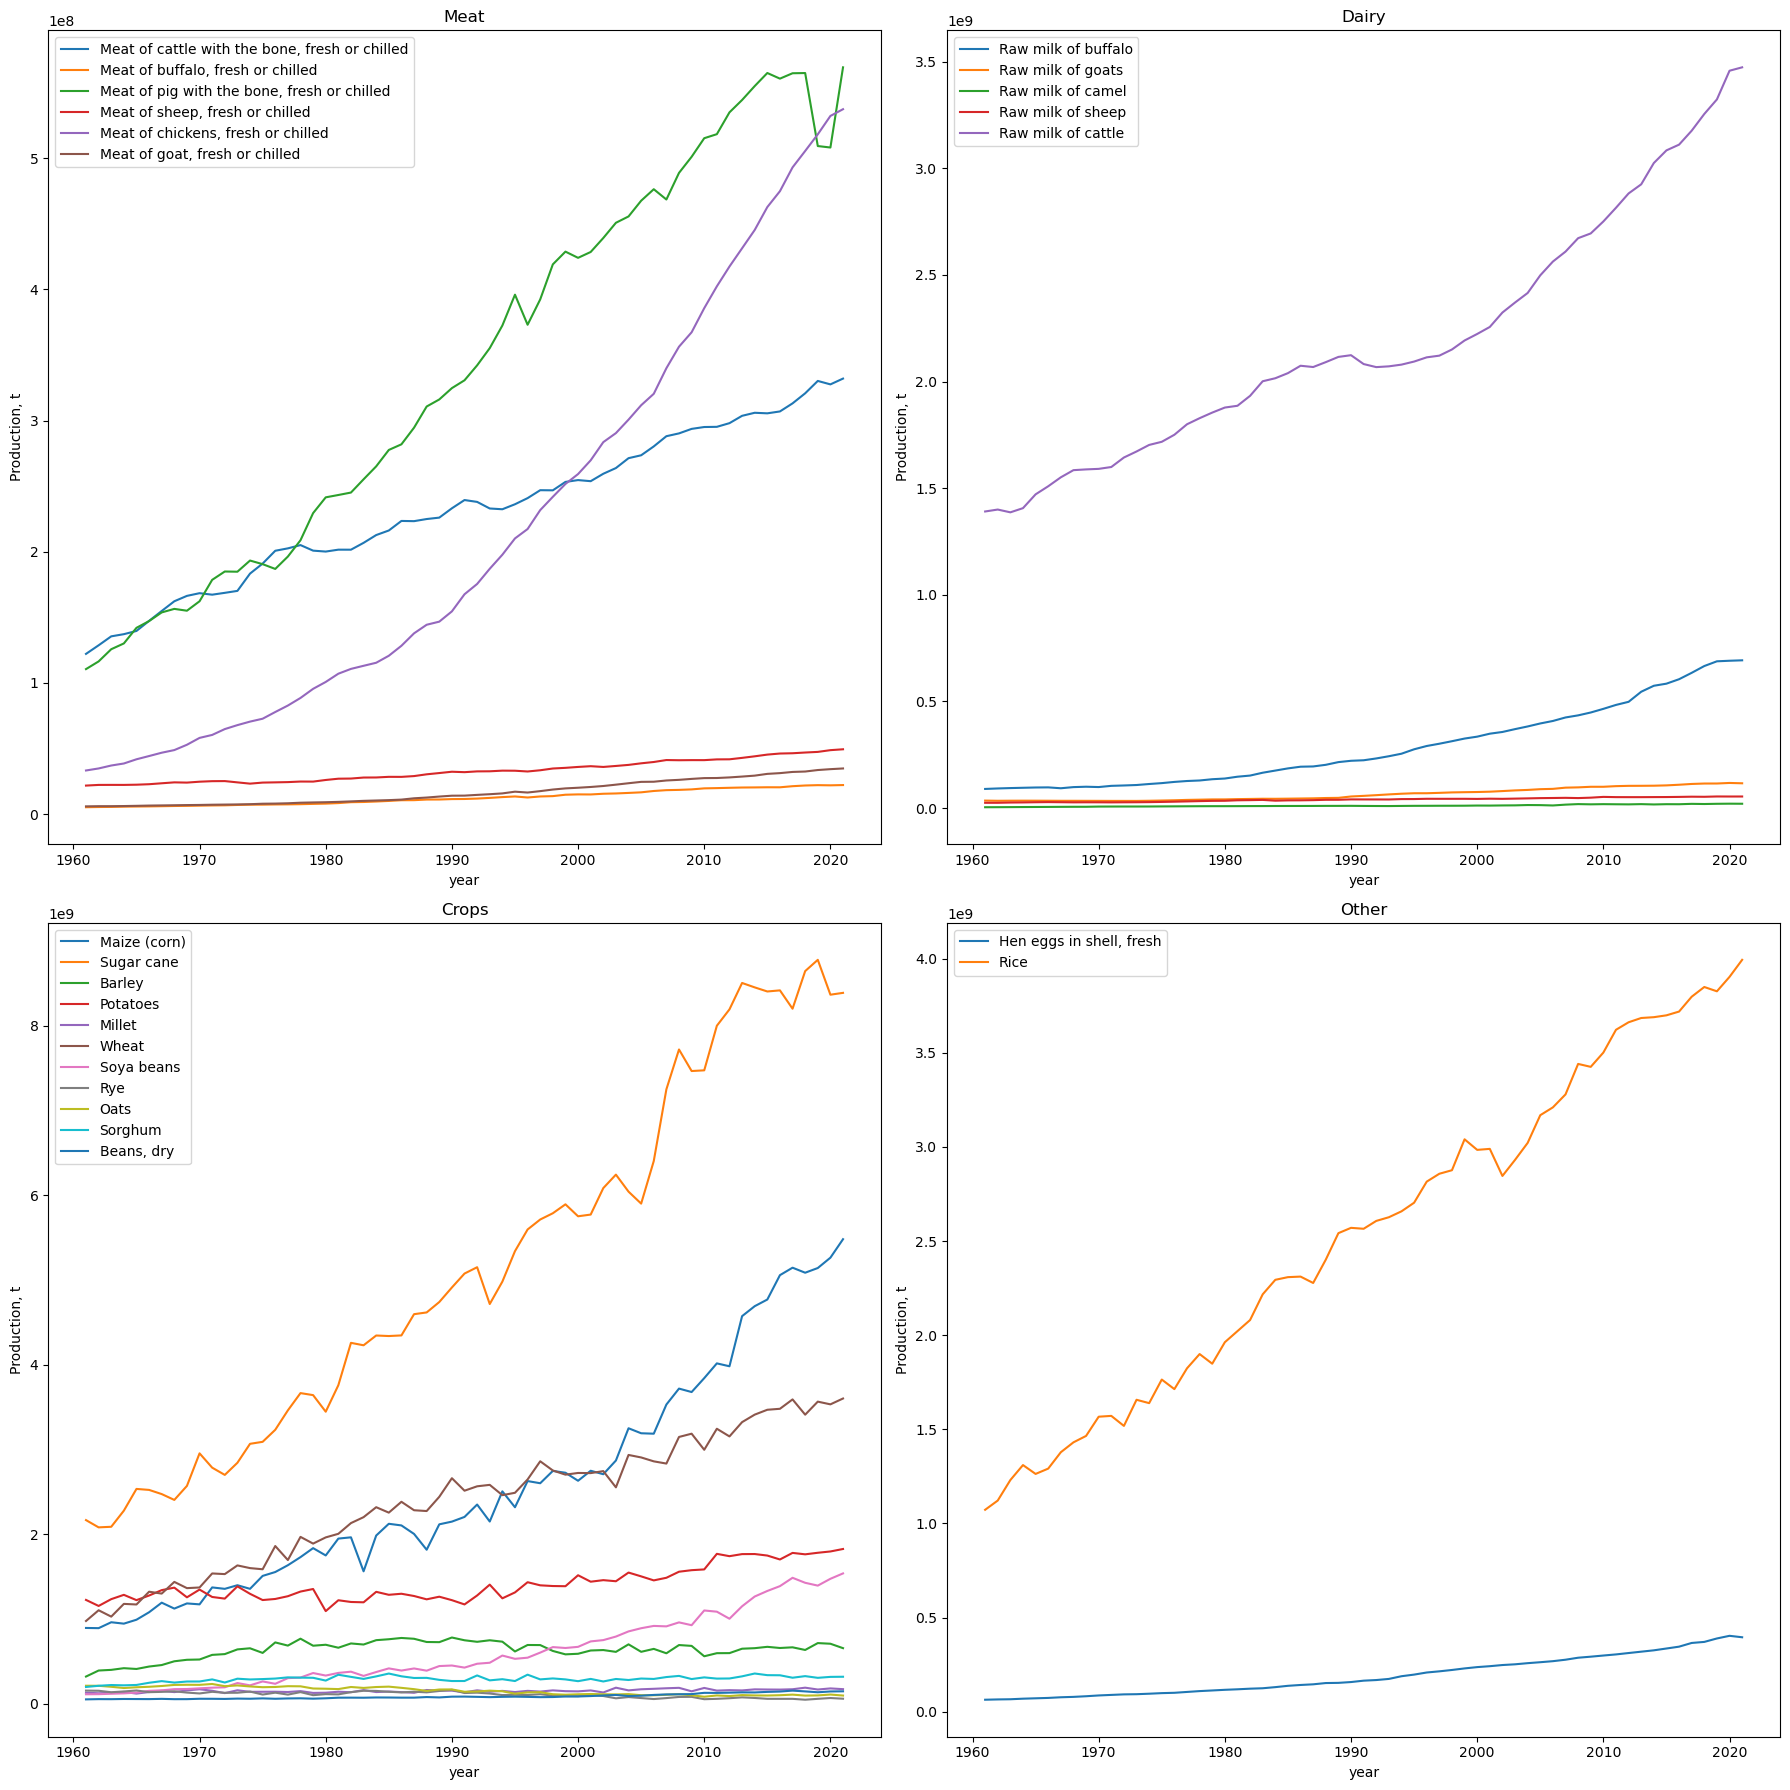

In [78]:
# Plot production development of meat and crop food items over time. 
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18) )

# Iterate over livestock_meat items
for item in livestock_meat:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[0,0], label=item)

axes[0,0].legend()
axes[0,0].set_ylabel('Production, t')
axes[0,0].set_title('Meat')

# Iterate over livestock_meat items
for item in livestock_milk:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[0,1], label=item)

axes[0,1].legend()
axes[0,1].set_ylabel('Production, t')
axes[0,1].set_title('Dairy')

# Iterate over crop items
for item in crops_primary_wo_rice:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[1,0], label=item)

axes[1,0].legend()
axes[1,0].set_ylabel('Production, t')
axes[1,0].set_title('Crops')

# Iterate over other items
for item in rice_and_eggs:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[1,1], label=item)

axes[1,1].legend()
axes[1,1].set_ylabel('Production, t')
axes[1,1].set_title('Other')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

### Production by country

In [117]:
production_amount_country = df_production[(df_production['area_group'] == 'no') & (df_production['area'] != 'China')]\
    [['area', 'population', 'production_in_t']]\
    .groupby(['area'], as_index=False)\
    .agg('sum')

In [119]:
# Calculating production per capita
production_amount_country['production_per_capita'] = production_amount_country['production_in_t'] / production_amount_country['population']

In [120]:
production_amount_country.head()

,area,population,production_in_t,production_per_capita
0,Afghanistan,88589107224,5.256926e+08,0.005934
1,Albania,16978471872,1.627595e+08,0.009586
2,Algeria,178192259963,7.503656e+08,0.004211
3,Angola,64804458200,5.747982e+08,0.008870
4,Antigua and Barbuda,217169288,2.602198e+06,0.011982


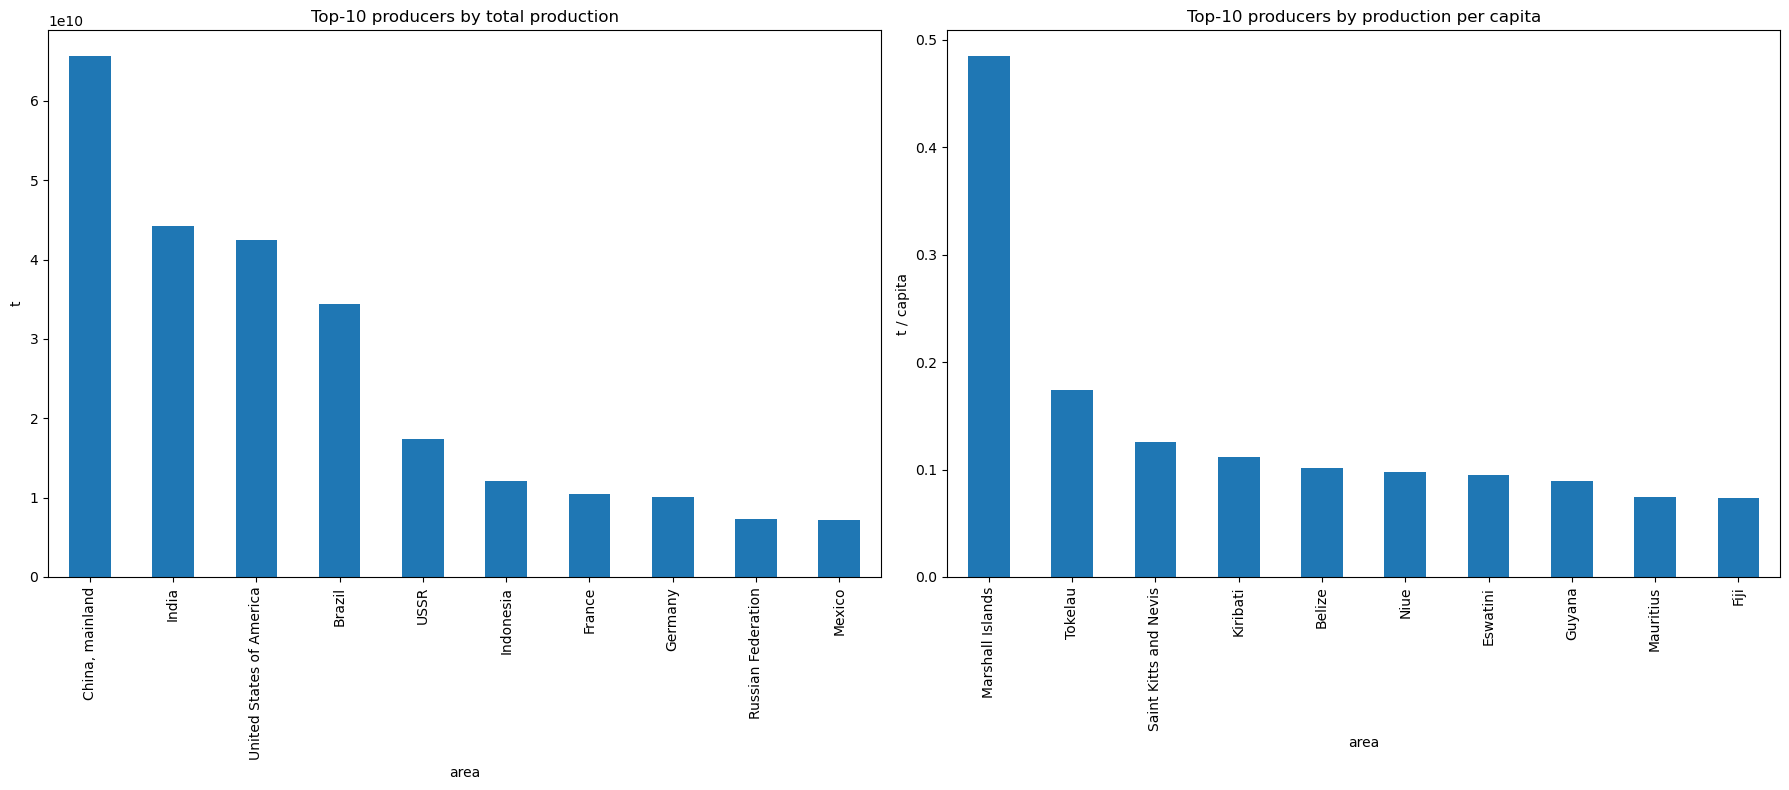

In [127]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot the top-10 agricultural producers by total production
production_amount_country.sort_values(by='production_in_t', ascending=False)\
    .head(10).plot.bar(x='area', y='production_in_t', ax=axes[0], logy=False)
axes[0].set_title('Top-10 food producers by total production')
axes[0].get_legend().remove()
axes[0].set_ylabel('t')

# Plot the top-10 agricultural producers by production per capita
production_amount_country.sort_values(by='production_per_capita', ascending=False)\
    .head(10).plot.bar(x='area', y='production_per_capita', ax=axes[1], logy=False)
axes[1].set_title('Top-10 food producers by production per capita')
axes[1].get_legend().remove()
axes[1].set_ylabel('t / capita')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### Emissions by country

In [128]:
production_amount_country = df_production[(df_production['area_group'] == 'no') & (df_production['area'] != 'China')]\
    [['area', 'population', 'emissions_co2eq_in_kt']]\
    .groupby(['area'], as_index=False)\
    .agg('sum')

In [132]:
# Calculating emissions per capita
production_amount_country['emissions_per_capita'] = production_amount_country['emissions_co2eq_in_kt'] / production_amount_country['population']

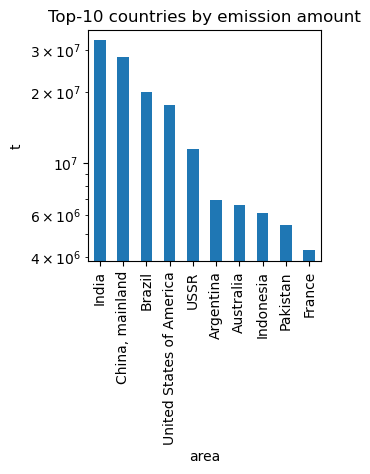

In [131]:
# Plot the top-10 countries by emission amount
fig, ax = plt.subplots(figsize=(3, 3))
production_amount_country.sort_values(by='emissions_co2eq_in_kt', ascending=False)\
    .head(10).plot.bar(x='area', y='emissions_co2eq_in_kt', ax=ax, logy=True)
ax.set_title('Top-10 countries by emission amount')
ax.get_legend().remove()
ax.set_ylabel('t')
plt.show()

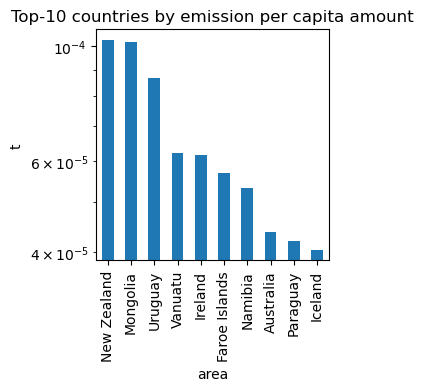

In [133]:
# Plot the top-10 countries by emission amount per capita
fig, ax = plt.subplots(figsize=(3, 3))
production_amount_country.sort_values(by='emissions_per_capita', ascending=False)\
    .head(10).plot.bar(x='area', y='emissions_per_capita', ax=ax, logy=True)
ax.set_title('Top-10 countries by emission per capita amount')
ax.get_legend().remove()
ax.set_ylabel('t')
plt.show()